# Importance Score Windows by 5' and 3' bases

In [1]:
import tensorflow as tf
import os
cwd = os.getcwd()
os.chdir('../../src/')
from dataloader import OneHotEncoder, load_fasta_data, RNASeqDataGenerator
os.chdir('../experiments/ImportanceScoreWindow/')

In [2]:
be_type='CBE'
sample='161F'
be_class='A3A'

data_dir = "../../data/raw/{0}/{0}-sequence/".format(be_type)

train_chr = [str(x) for x in range(1, 20)]
test_chr = [str(x) for x in range(20, 23)] +['X']
train_seqs, train_ers, test_seqs, test_ers = [], [], [], []

for rep in train_chr:
        seq, er = load_fasta_data(sample, rep, data_dir)
        train_seqs = seq+train_seqs
        train_ers = er+train_ers
for rep in test_chr:
        seq, er = load_fasta_data(sample, rep, data_dir)
        test_seqs = seq+test_seqs
        test_ers = er+test_ers

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:05.0, compute capability: 3.7



In [4]:
model = tf.keras.models.load_model('../../models/CNN/{}/{}.h5'.format(be_type, sample))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
import shap
train_dat_gen = RNASeqDataGenerator(train_seqs, train_ers, logits=False)
test_dat_gen = RNASeqDataGenerator(test_seqs, test_ers, logits=False)

In [6]:
pred = model.predict(train_dat_gen[1])

In [7]:
from tqdm import tqdm
import numpy as np
X_bg = list()
y_bg = list()
th = 0.01
inp = np.arange(len(train_dat_gen))
np.random.shuffle(inp)
for x in tqdm(inp):
    inp_data = train_dat_gen[x][0]
    gt = train_dat_gen[x][1]
    preds = model.predict(inp_data)
    for index in range(inp_data.shape[0]):
        if (preds[index]<th):
            X_bg.append(inp_data[index])
            y_bg.append(gt[index])
    if len(y_bg)>4096:
        break;
X_bg_set = np.array(X_bg)

  0%|          | 77/25724 [00:01<05:56, 71.89it/s]


In [8]:
shap_explainer = shap.DeepExplainer(model, X_bg_set)

Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


In [10]:
from tqdm import tqdm
shp_acc = list()
x_acc=list()
preds_acc=list()
gt_acc = list()
for i in tqdm(range(10)):
    shp_acc.append(shap_explainer.shap_values(test_dat_gen[i][0])[0])
    x_acc.append(test_dat_gen[i][0])
    preds_acc.append(model.predict(test_dat_gen[i][0]).reshape((64,1)))
    gt_acc.append(np.array(test_dat_gen[i][1]).reshape((64,1)))
shp = np.vstack(shp_acc)
x_shp = np.vstack(x_acc)
preds_shp = np.vstack(preds_acc)
gt_shp = np.vstack(gt_acc)

100%|██████████| 10/10 [04:03<00:00, 24.35s/it]


In [11]:
shp_norm = np.abs(shp*x_shp)

In [12]:
inner = np.sum(np.sum(shp_norm, axis=2)[:,47:54], axis=1)
outer = np.sum(np.sum(shp_norm, axis=2)[:,0:47] + np.sum(shp_norm, axis=2)[:,54:], axis=1)
frac = inner/(inner+outer)

In [13]:
frac.shape

(640,)

# Export

In [14]:
# 5' base
base5 = []
for x in range(shp_norm.shape[0]):
    if x_shp[x][49][0]==1:
        base5.append('A')
    elif x_shp[x][49][1]==1:
        base5.append('C')
    elif x_shp[x][49][2]==1:
        base5.append('G')
    elif x_shp[x][49][3]==1:
        base5.append('T')

In [15]:
# 3' base
base3 = []
for x in range(shp_norm.shape[0]):
    if x_shp[x][51][0]==1:
        base3.append('A')
    elif x_shp[x][51][1]==1:
        base3.append('C')
    elif x_shp[x][51][2]==1:
        base3.append('G')
    elif x_shp[x][51][3]==1:
        base3.append('T')

In [16]:
import pandas as pd
d = {'EditRate': gt_shp.flatten(), 'PredRate': preds_shp.flatten(), '5Base':base5, '3base':base3, 'ImpFrac':frac.flatten()}
df = pd.DataFrame(data=d)

In [ ]:
df.to_csv('A3A.csv', index=False) 

Text(0.5, 1.0, 'Fraction of importance scores in middle 7 bases')

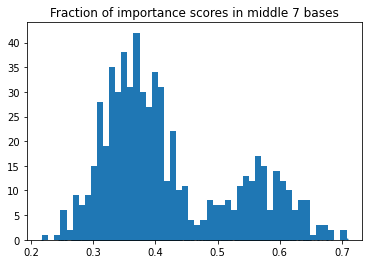

In [17]:
import matplotlib.pyplot as plt
plt.scatter(frac, preds_shp, s=1)
plt.hist(frac, bins=50)
plt.title('Fraction of importance scores in middle 7 bases')

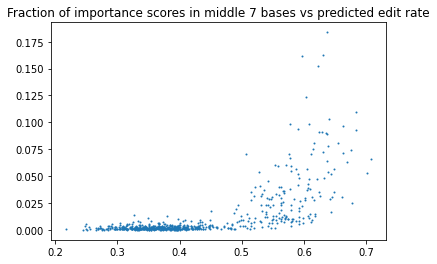

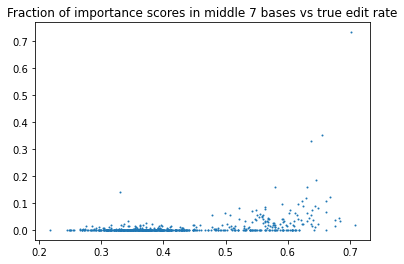

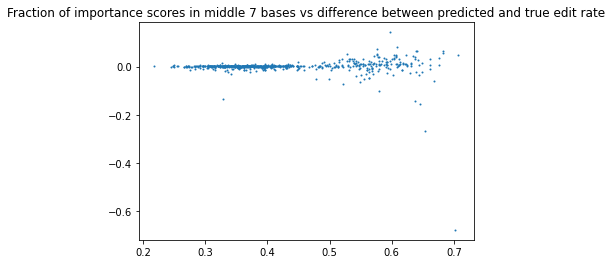

In [18]:
preds_shp.shape
frac.shape
plt.scatter(frac, preds_shp, s=1)
plt.title('Fraction of importance scores in middle 7 bases vs predicted edit rate')
plt.show()
plt.scatter(frac, gt_shp, s=1)
plt.title('Fraction of importance scores in middle 7 bases vs true edit rate')
plt.show()
plt.scatter(frac, preds_shp-gt_shp, s=1)
plt.title('Fraction of importance scores in middle 7 bases vs difference between predicted and true edit rate')
plt.show()

# Histogram by 5' and 3' bases

In [19]:
shp_norm = np.abs(shp*x_shp)

In [20]:
x_shp.shape

(640, 101, 4)

In [21]:
# 5' base
a_shp = []
c_shp = []
g_shp = []
t_shp = []
for x in range(shp_norm.shape[0]):
    if x_shp[x][49][0]==1:
        a_shp.append(shp_norm[x])
    elif x_shp[x][49][1]==1:
        c_shp.append(shp_norm[x])
    elif x_shp[x][49][2]==1:
        g_shp.append(shp_norm[x])
    elif x_shp[x][49][3]==1:
        t_shp.append(shp_norm[x])

In [22]:
shp_a = np.stack(a_shp)
shp_c = np.stack(c_shp)   
shp_g = np.stack(g_shp)   
shp_t = np.stack(t_shp)   

Text(0.5, 1.0, "Fraction of importance scores in middle 7 bases with 5' A")

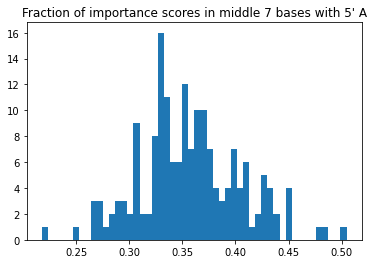

In [23]:
import matplotlib.pyplot as plt

inner = np.sum(np.sum(shp_a, axis=2)[:,47:54], axis=1)
outer = np.sum(np.sum(shp_a, axis=2)[:,0:47] + np.sum(shp_a, axis=2)[:,54:], axis=1)
frac = inner/(inner+outer)

plt.hist(frac, bins=50)
plt.title("Fraction of importance scores in middle 7 bases with 5' A")

Text(0.5, 1.0, "Fraction of importance scores in middle 7 bases with 5' C")

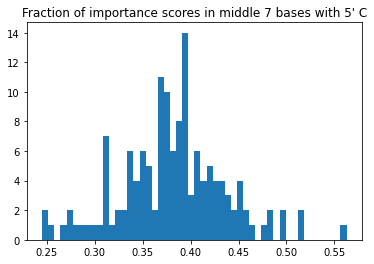

In [24]:
import matplotlib.pyplot as plt

inner = np.sum(np.sum(shp_c, axis=2)[:,47:54], axis=1)
outer = np.sum(np.sum(shp_c, axis=2)[:,0:47] + np.sum(shp_c, axis=2)[:,54:], axis=1)
frac = inner/(inner+outer)

plt.hist(frac, bins=50)
plt.title("Fraction of importance scores in middle 7 bases with 5' C")

Text(0.5, 1.0, "Fraction of importance scores in middle 7 bases with 5' G")

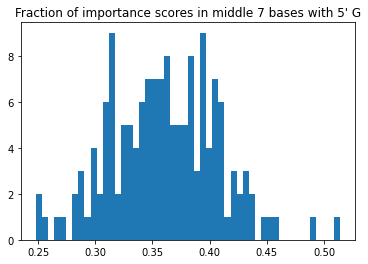

In [25]:
import matplotlib.pyplot as plt

inner = np.sum(np.sum(shp_g, axis=2)[:,47:54], axis=1)
outer = np.sum(np.sum(shp_g, axis=2)[:,0:47] + np.sum(shp_g, axis=2)[:,54:], axis=1)
frac = inner/(inner+outer)

plt.hist(frac, bins=50)
plt.title("Fraction of importance scores in middle 7 bases with 5' G")

Text(0.5, 1.0, "Fraction of importance scores in middle 7 bases with 5' T")

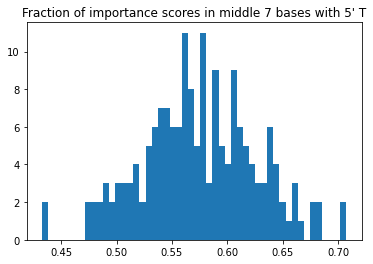

In [26]:
import matplotlib.pyplot as plt

inner = np.sum(np.sum(shp_t, axis=2)[:,47:54], axis=1)
outer = np.sum(np.sum(shp_t, axis=2)[:,0:47] + np.sum(shp_t, axis=2)[:,54:], axis=1)
frac = inner/(inner+outer)

plt.hist(frac, bins=50)
plt.title("Fraction of importance scores in middle 7 bases with 5' T")

In [27]:
# 3' base
a_shp = []
c_shp = []
g_shp = []
t_shp = []
for x in range(shp_norm.shape[0]):
    if x_shp[x][51][0]==1:
        a_shp.append(shp_norm[x])
    elif x_shp[x][51][1]==1:
        c_shp.append(shp_norm[x])
    elif x_shp[x][51][2]==1:
        g_shp.append(shp_norm[x])
    elif x_shp[x][51][3]==1:
        t_shp.append(shp_norm[x])

In [28]:
shp_a = np.stack(a_shp)
shp_c = np.stack(c_shp)   
shp_g = np.stack(g_shp)   
shp_t = np.stack(t_shp)

Text(0.5, 1.0, "Fraction of importance scores in middle 7 bases with 3' A")

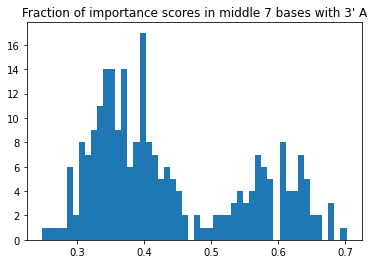

In [29]:
import matplotlib.pyplot as plt

inner = np.sum(np.sum(shp_a, axis=2)[:,47:54], axis=1)
outer = np.sum(np.sum(shp_a, axis=2)[:,0:47] + np.sum(shp_a, axis=2)[:,54:], axis=1)
frac = inner/(inner+outer)

plt.hist(frac, bins=50)
plt.title("Fraction of importance scores in middle 7 bases with 3' A")

Text(0.5, 1.0, "Fraction of importance scores in middle 7 bases with 3' C")

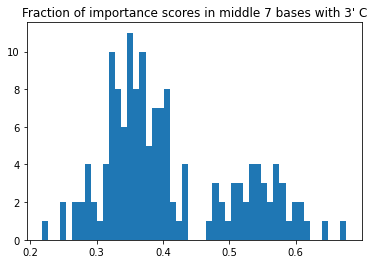

In [30]:
import matplotlib.pyplot as plt

inner = np.sum(np.sum(shp_c, axis=2)[:,47:54], axis=1)
outer = np.sum(np.sum(shp_c, axis=2)[:,0:47] + np.sum(shp_c, axis=2)[:,54:], axis=1)
frac = inner/(inner+outer)

plt.hist(frac, bins=50)
plt.title("Fraction of importance scores in middle 7 bases with 3' C")

Text(0.5, 1.0, "Fraction of importance scores in middle 7 bases with 3' G")

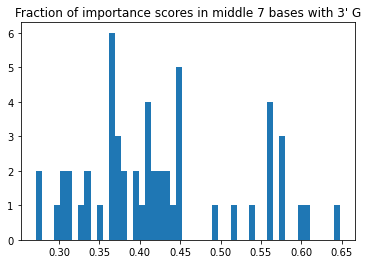

In [31]:
import matplotlib.pyplot as plt

inner = np.sum(np.sum(shp_g, axis=2)[:,47:54], axis=1)
outer = np.sum(np.sum(shp_g, axis=2)[:,0:47] + np.sum(shp_g, axis=2)[:,54:], axis=1)
frac = inner/(inner+outer)

plt.hist(frac, bins=50)
plt.title("Fraction of importance scores in middle 7 bases with 3' G")

Text(0.5, 1.0, "Fraction of importance scores in middle 7 bases with 3' T")

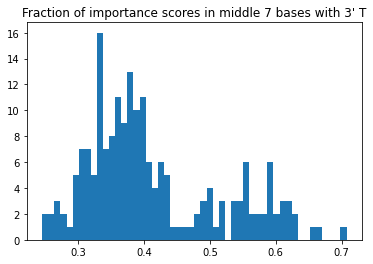

In [32]:
import matplotlib.pyplot as plt

inner = np.sum(np.sum(shp_t, axis=2)[:,47:54], axis=1)
outer = np.sum(np.sum(shp_t, axis=2)[:,0:47] + np.sum(shp_t, axis=2)[:,54:], axis=1)
frac = inner/(inner+outer)

plt.hist(frac, bins=50)
plt.title("Fraction of importance scores in middle 7 bases with 3' T")